## Identification Rate Metric

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар в порядке убывания. N — ое значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние больше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

**Для подсчета метрик, то вам нужно разбить данные на query и distractors самим.**

Делается это примерно так:
- Выбраете несколько id, которые не использовались при тренировке моделей, и помещаете их в query set;
- Выбираете несколько id, которые не использовались при тренировке моделей и не входят в query, и помещаете их в distractors set. Обычно distractors set должен быть сильно больше, чем query set.
- Обрабатываете картинки из query и distractors тем же способом, что картинки для обучения сети.


Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

## План заданий

* Правильно разбить датасет на query и distractors
* Реализовать метрику и пройти все тесты
* Подгрузить все модели, обученные на разных лоссах и сравнить их метрики

## Шаблон кода для Identificaton rate metric (TPR@FPR)

In [1]:
import numpy as np
from itertools import combinations
import torch
import cv2
from torchvision import transforms
from PIL import Image

def compute_embeddings(model, images_list):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize(350),
      transforms.Pad((0, 0, 0, 50)),
      transforms.CenterCrop(224),
      transforms.Normalize((0.485, 0.456, 0.406),
                           (0.229, 0.224, 0.225))
  ])

  model.eval()
  device = next(model.parameters()).device
  embeddings = []

  with torch.no_grad():
    for image_path in images_list:
      image = Image.open(image_path).convert('RGB')  # PIL image
      image = transform(image).unsqueeze(0).to(device)  # shape: (1, 3, H, W)
      embedding = model(image)
      embeddings.append(embedding.squeeze(0).cpu().numpy())

  return embeddings

In [ ]:
query_embeddings = compute_embeddings(model, query_img_names)
distractors_embeddings = compute_embeddings(model, distractors_img_names)

In [39]:
def cosine_sim(emb1, emb2):
    emb1 = np.asarray(emb1).flatten()
    emb2 = np.asarray(emb2).flatten()
    return float(np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2)))

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
  '''
  name_to_emb = {name: emb for name, emb in zip(query_img_names, query_embeddings)}
  similarities = []

  for class_images in query_dict.values():
    if len(class_images) < 2:
      continue
    for i in range(len(class_images)):
      for j in range(i + 1, len(class_images)):
        emb1 = name_to_emb[class_images[i]]
        emb2 = name_to_emb[class_images[j]]
        #cos_sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        similarities.append(cosine_sim(emb1, emb2))

  return similarities

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list
  '''
  name_to_emb = {name: emb for name, emb in zip(query_img_names, query_embeddings)}
  similarities = []

  class_list = list(query_dict.values())
  for i in range(len(class_list)):
    for j in range(i + 1, len(class_list)):
      imgs_i = class_list[i]
      imgs_j = class_list[j]
      for img_i in imgs_i:
        for img_j in imgs_j:
          emb1 = name_to_emb[img_i]
          emb2 = name_to_emb[img_j]
          #cos_sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
          similarities.append(cosine_sim(emb1, emb2))

  return similarities

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
    '''
    
    similarities = []
    for q_emb in query_embeddings:
        for d_emb in distractors_embeddings:
            #cos_sim = np.dot(q_emb, d_emb) / (np.linalg.norm(q_emb) * np.linalg.norm(d_emb))
            similarities.append(cosine_sim(q_emb, d_emb))

    return similarities

Ячейка ниже проверяет, что код работает верно:

In [40]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [41]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

И, наконец, финальная функция, которая считает IR metric:

In [42]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
  '''
  compute identification rate using precomputed cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output:
    float: threshold for given fpr
    float: TPR at given FPR
  '''
  # Все отрицательные пары (разные люди)
  false_pairs = cosine_query_neg + cosine_query_distractors
  false_pairs_sorted = sorted(false_pairs, reverse=True)

  # Сколько false positive допускаем при заданном fpr
  num_false_total = len(false_pairs)
  num_false_allowed = int(fpr * num_false_total)

  # Порог по значению cosine similarity
  threshold = false_pairs_sorted[num_false_allowed] if num_false_allowed < len(false_pairs_sorted) else false_pairs_sorted[-1]

  # Считаем, сколько положительных пар выше порога
  true_positive_count = sum(sim > threshold for sim in cosine_query_pos)
  total_positive = len(cosine_query_pos)
  tpr = true_positive_count / total_positive if total_positive > 0 else 0.0

  return threshold, tpr

И ячейки для ее проверки:

In [6]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [7]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

In [68]:
import os, shutil, random, csv
from collections import defaultdict, Counter

# Пути
wild_src_dir = r"C:\ML_DLS\Final_Project\dataset\Wild\img_celeba"
identity_file = r"C:\ML_DLS\Final_Project\dataset\Anno\identity_CelebA.txt"

output_base = r"C:\ML_DLS\Final_Project\eval_dataset"
query_dir = os.path.join(output_base, "query")
distractor_dir = os.path.join(output_base, "distractors")
os.makedirs(query_dir, exist_ok=True)
os.makedirs(distractor_dir, exist_ok=True)

# === Чтение идентичностей ===
id_map = {}
with open(identity_file, "r") as f:
    for line in f:
        img_name, identity = line.strip().split()
        id_map[img_name] = int(identity)

# === ID, использовавшиеся при обучении (топ 500)
id_counter = Counter(id_map.values())
top_500_ids = {id_ for id_, _ in id_counter.most_common(500)}

# === Собираем изображения неиспользованных ID
images_by_id = defaultdict(list)
for img_name, identity in id_map.items():
    if identity not in top_500_ids:
        images_by_id[identity].append(img_name)

# === Оставляем только ID с достаточным числом изображений
eligible_ids = [id_ for id_, imgs in images_by_id.items() if len(imgs) >= 3]
random.seed(42)
random.shuffle(eligible_ids)

if len(eligible_ids) < 80:
    raise ValueError("Недостаточно уникальных идентичностей вне top-500 (нужно ≥80)")

query_ids = eligible_ids[:20]
distractor_ids = eligible_ids[20:80]  # 60 ID

# === Создание CSV
query_csv = os.path.join(output_base, "query.csv")
distractor_csv = os.path.join(output_base, "distractors.csv")
with open(query_csv, "w", newline="") as f_q, open(distractor_csv, "w", newline="") as f_d:
    writer_q = csv.writer(f_q)
    writer_d = csv.writer(f_d)
    writer_q.writerow(["img", "id_true"])
    writer_d.writerow(["img", "id_true"])

    # --- Обработка Query (20 ID по 3 фото)
    for identity in query_ids:
        images = images_by_id[identity]
        random.shuffle(images)
        selected = images[:3]
        for img_name in selected:
            src = os.path.join(wild_src_dir, img_name)
            dst = os.path.join(query_dir, img_name)
            shutil.copyfile(src, dst)
            writer_q.writerow([img_name, identity])

    # --- Обработка Distractors (60 ID по 2 фото)
    for identity in distractor_ids:
        images = images_by_id[identity]
        random.shuffle(images)
        selected = images[:2]
        for img_name in selected:
            src = os.path.join(wild_src_dir, img_name)
            dst = os.path.join(distractor_dir, img_name)
            shutil.copyfile(src, dst)
            writer_d.writerow([img_name, identity])

print("✅ Готово: Query (20x3) и Distractors (60x2) сформированы из wild изображений.")


✅ Готово: Query (20x3) и Distractors (60x2) сформированы из wild изображений.


In [21]:
import torch
import models
import sys
import contextlib
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from skimage.transform import SimilarityTransform, warp
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Загрузим модель для определения landmarks
with open(os.devnull, 'w') as f, contextlib.redirect_stdout(f):
    model_FaceAlignment = models.LandmarksNet()
    model_FaceAlignment.load_state_dict(torch.load("./weights/best_model_FaceAligment.pth"))
    model_FaceAlignment.to(device)
    model_FaceAlignment.eval()

In [22]:
def predict_and_align(
    image_rgb,
    img_name,
    model,
    bbox_df,
    template,
    show=True,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    image_size=(160, 192)
):
    """
    Предсказание landmarks и выравнивание шаблону, используя готовое изображение и имя.

    :param image_rgb: np.ndarray (H, W, 3) — исходное RGB изображение
    :param img_name: строка — имя изображения (для поиска bbox)
    :param model: torch-модель
    :param bbox_df: DataFrame с bbox аннотациями
    :param show: показывать результат или возвращать
    :return: (aligned_image, aligned_landmarks) если show=False
    """

    # === Получаем bbox ===
    bbox = bbox_df.set_index("image_id").loc[img_name]
    x, y, w, h = int(bbox['x_1']), int(bbox['y_1']), int(bbox['width']), int(bbox['height'])

    # === Crop + resize
    image_crop = image_rgb[y:y+h, x:x+w]
    resized = cv2.resize(image_crop, image_size)  # (160x192)
    input_tensor = torch.tensor(resized.astype(np.float32) / 255.).permute(2, 0, 1).unsqueeze(0).to(device)

    # === Предсказание heatmaps
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)           # [1, N, 5, 48, 40]
        heatmaps_pred = output[:, -1]          # [1, 5, 48, 40]

    upsampled = F.interpolate(heatmaps_pred, size=(image_size[1], image_size[0]), mode='bilinear', align_corners=False)
    upsampled = upsampled.squeeze(0).cpu().numpy()  # [5, H, W]

    # === Извлекаем landmarks
    pred_landmarks = []
    for i in range(5):
        y_hm, x_hm = np.unravel_index(np.argmax(upsampled[i]), upsampled[i].shape)
        pred_landmarks.append([x_hm, y_hm])
    pred_landmarks = np.array(pred_landmarks, dtype=np.float32)



    # === Выравнивание изображения
    tform = SimilarityTransform()
    if not tform.estimate(pred_landmarks, template):
        raise ValueError("Не удалось найти similarity transform.")
    aligned = warp(resized, tform.inverse, output_shape=(image_size[1], image_size[0]), preserve_range=True).astype(np.uint8)

    # === Преобразование landmarks → в aligned-изображение
    aligned_landmarks = tform(pred_landmarks)  # <<<<<< ВАЖНО!

    # === Отрисовка
    if show:
        vis1 = resized.copy()
        vis2 = aligned.copy()
        for (x_lm, y_lm) in pred_landmarks.astype(int):
            cv2.circle(vis1, (x_lm, y_lm), 3, (255, 0, 0), -1)
        for (x_lm, y_lm) in aligned_landmarks.astype(int):
            cv2.circle(vis2, (x_lm, y_lm), 3, (0, 255, 0), -1)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(vis1)
        plt.title(f"Before Alignment: {img_name}")
        plt.grid()
        plt.subplot(1, 2, 2)
        plt.imshow(vis2)
        plt.title("Aligned")
        plt.grid()
        plt.show()
        return

    else:
        return aligned, aligned_landmarks

# Предварительно загружаем данные
bbox_dir=r".\dataset_500\list_bbox_celeba.txt"
img_dir = r".\eval_dataset\query"
img_list = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]
img_name = random.choice(img_list)

img_path = os.path.join(img_dir, img_name)
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

bbox_df = pd.read_csv(bbox_dir, sep='\s+', header=1)

# Запускаем
#predict_and_align(image_rgb, img_name, model_FaceAlignment, bbox_df, template=models.TEMPLATE, show=True)


<>:92: SyntaxWarning: invalid escape sequence '\s'
<>:92: SyntaxWarning: invalid escape sequence '\s'
C:\Users\VolkovAP\AppData\Local\Temp\ipykernel_25816\3778105815.py:92: SyntaxWarning: invalid escape sequence '\s'
  bbox_df = pd.read_csv(bbox_dir, sep='\s+', header=1)


In [72]:
# Пути
input_dir = r".\eval_dataset\query"
output_dir = r".\eval_dataset\query_aligned"
bbox_path = r".\dataset_500\list_bbox_celeba.txt"

# Загрузка bbox
bbox_df = pd.read_csv(bbox_path, sep='\s+', header=1)

# Создаём выходную директорию, если нужно
os.makedirs(output_dir, exist_ok=True)

# Список изображений
img_list = [f for f in os.listdir(input_dir) if f.endswith(".jpg")]

# Обработка всех изображений
for img_name in tqdm(img_list, desc="Обработка изображений"):
    img_path = os.path.join(input_dir, img_name)

    # Чтение изображения
    image_bgr = cv2.imread(img_path)
    if image_bgr is None:
        print(f"❌ Пропущено: {img_name} (не удалось загрузить)")
        continue
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    try:
        # Выравнивание лица без отображения
        aligned_face, _ = predict_and_align(
            image_rgb=image_rgb,
            img_name=img_name,
            model=model_FaceAlignment,
            bbox_df=bbox_df,
            template=models.TEMPLATE,
            show=False  # не показываем
        )

        # Сохраняем как BGR JPG
        out_path = os.path.join(output_dir, img_name)
        face_bgr = cv2.cvtColor(aligned_face, cv2.COLOR_RGB2BGR)
        cv2.imwrite(out_path, face_bgr)

    except Exception as e:
        print(f"⚠️ Ошибка на {img_name}: {e}")

<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
C:\Users\VolkovAP\AppData\Local\Temp\ipykernel_25384\1447286538.py:7: SyntaxWarning: invalid escape sequence '\s'
  bbox_df = pd.read_csv(bbox_path, sep='\s+', header=1)
Обработка изображений: 100%|███████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.29it/s]


# Сделаем  query_dict, query_img_names, distractors_img_names

In [23]:
import csv
from collections import defaultdict

def load_query_and_distractors(csv_query_path, csv_distractor_path):
    '''
    Построить query_dict, query_img_names и distractors_img_names из CSV файлов

    params:
      csv_query_path: путь к query.csv
      csv_distractor_path: путь к distractors.csv

    returns:
      query_dict: dict {id_true: [img1, img2, ...]}
      query_img_names: list of all image names in query
      distractors_img_names: list of all image names in distractors
    '''
    query_dict = defaultdict(list)
    query_img_names = []
    distractors_img_names = []

    # Обработка query.csv
    with open(csv_query_path, 'r') as f_q:
        reader = csv.DictReader(f_q)
        for row in reader:
            img = row['img']
            id_true = int(row['id_true'])
            query_dict[id_true].append(img)
            query_img_names.append(img)

    # Обработка distractors.csv
    with open(csv_distractor_path, 'r') as f_d:
        reader = csv.DictReader(f_d)
        for row in reader:
            img = row['img']
            distractors_img_names.append(img)

    return query_dict, query_img_names, distractors_img_names

query_dict, query_img_names, distractors_img_names = load_query_and_distractors(
    csv_query_path=r'C:\ML_DLS\Final_Project\eval_dataset\query.csv',
    csv_distractor_path=r'C:\ML_DLS\Final_Project\eval_dataset\distractors.csv'
)

In [24]:
# Пути к изображениям

query_img_paths = [os.path.join(r'C:\ML_DLS\Final_Project\eval_dataset\query_aligned', name)
                   for name in query_img_names]

distractor_img_paths = [os.path.join(r'C:\ML_DLS\Final_Project\eval_dataset\distractors_aligned', name)
                        for name in distractors_img_names]

In [25]:
query_embeddings = compute_embeddings(model_FaceAlignment, query_img_paths)
distractor_embeddings = compute_embeddings(model_FaceAlignment, distractor_img_paths)

In [43]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)

In [46]:
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)

In [47]:
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractor_embeddings)

In [50]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(cosine_query_pos, cosine_query_neg,
                    cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [51]:
for fpr_val, thr, tpr in zip([0.5, 0.3, 0.1], test_thr, test_tpr):
    print(f"FPR={fpr_val:.2f} → Threshold={thr:.4f}, TPR={tpr:.4f}")

FPR=0.50 → Threshold=0.1953, TPR=0.5667
FPR=0.30 → Threshold=0.2773, TPR=0.4167
FPR=0.10 → Threshold=0.4095, TPR=0.2667


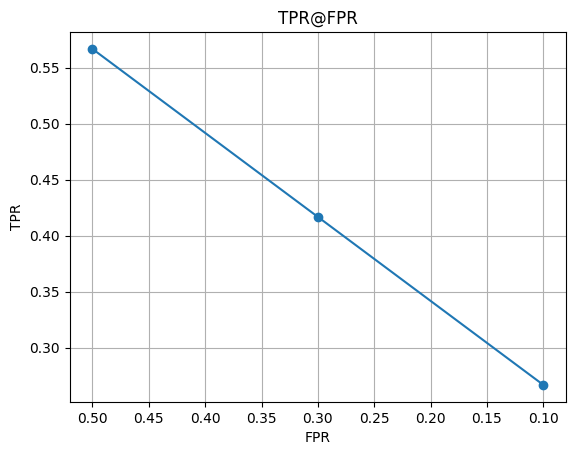

In [52]:
import matplotlib.pyplot as plt

fpr_values = [0.5, 0.3, 0.1]

plt.plot(fpr_values, test_tpr, marker='o')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("TPR@FPR")
plt.gca().invert_xaxis()  # чтобы 0.1 справа, 0.5 слева
plt.grid(True)
plt.show()